# Machine Intelligence II - Team MensaNord
## Sheet 11

- Nikolai Zaki
- Alexander Moore
- Johannes Rieke
- Georg Hoelger
- Oliver Atanaszov

In [16]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import numpy as np
from scipy.ndimage import imread
import sys

### Exercise 1
- Load the data into a vector and normalize it such that the values are between 0 and 1.
- Create two new datasets by adding Gaussian noise with zero mean and standard deviation
σ N ∈ {0.05, 0.1}.

In [2]:
# import image
img_orig = imread('testimg.jpg').flatten()
print("$img_orig")
print("shape: \t\t", img_orig.shape) # = vector
print("values: \t from ", img_orig.min(), " to ", img_orig.max(), "\n")

# "img" holds 3 vectors
img = np.zeros((3,img_orig.shape[0]))
print("$img")
print("shape: \t\t",img.shape)

std = [0, 0.05, 0.1]
for i in range(img.shape[1]):
    # normalize => img[0]
    img[0][i] = img_orig[i] / 255
    # gaussian noise => img[1] img[2]
    img[1][i] = img[0][i] + np.random.normal(0, std[1])
    img[2][i] = img[0][i] + np.random.normal(0, std[2])
    
print(img[:, 0:4])

$img_orig
shape: 		 (177500,)
values: 	 from  0  to  255 

$img
shape: 		 (3, 177500)
[[ 0.63529412  0.63137255  0.62745098  0.63137255]
 [ 0.67858136  0.63816685  0.69517821  0.6407592 ]
 [ 0.56691858  0.57284359  0.62174947  0.46852629]]


- Create a figure showing the 3 histograms (original & 2 sets of noise corrupted data – use
enough bins!). In an additional figure, show the three corresponding empirical distribution
functions in one plot.

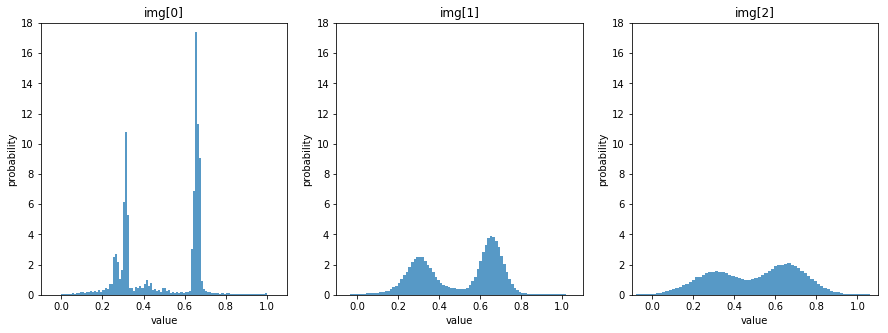

In [3]:
# histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.hist(img[i], 100, normed=1, alpha=0.75)
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 18)
    plt.xlabel("value")
    plt.ylabel("probability")
    plt.title('img[{}]'.format(i))

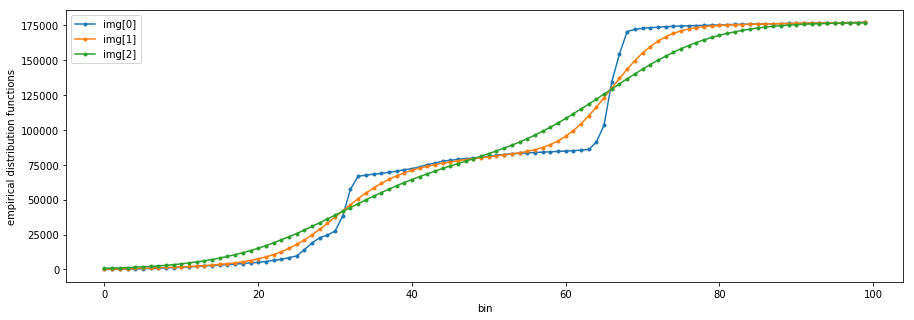

In [4]:
# divide probablity space in 100 bins
nbins = 100
bins = np.linspace(0, 1, nbins+1)

# holds data equivalent to shown histograms (but cutted from 0 to 1)
elementsPerBin = np.zeros((3,nbins))
for i in range(3):
    ind = np.digitize(img[i], bins)
    elementsPerBin[i] = [len(img[i][ind == j]) for j in range(nbins)]
    
# counts number of elements from bin '0' to bin 'j'
sumUptoBinJ = np.asarray([[0 for i in range(nbins)] for i in range(3)])
for i in range(3):
    for j in range(nbins):
        sumUptoBinJ[i][j] = np.sum(elementsPerBin[i][0:j+1])
    
# plot
plt.figure(figsize=(15, 5))
for i in range(3):
    plt.plot(sumUptoBinJ[i], '.-')
plt.legend(['img[0]', 'img[1]', 'img[2]'])
plt.xlabel('bin')
plt.ylabel('empirical distribution functions');

- Take a subset of P = 100 observations and estimate the probability density p̂ of intensities
with a rectangular kernel (“gliding window”) parametrized by window width h.
- Plot the estimates p̂ resulting for (e.g. 10) different samples of size P 

In [5]:
def H(vec, h):
    """
    (rectangular) histogram kernel function
    """
    vec = np.asarray(vec)
    return np.asarray([1 if abs(x)<.5 else 0 for x in vec])

### $P(\underline{x}) = \frac{1}{h^n} \frac{1}{p} \Sigma_{\alpha=1}^{p} H(\frac{\underline{x} - \underline{x}^{(\alpha)}}{h})$

In [6]:
def P_est(x, h, data, kernel = H):
    """
    returns the probability that data contains values @ (x +- h/2)
    """
    n = 1 #= data.shape[1] #number of dimensions (for multidmensional data)
    p = len(data)
    return 1/(h**n)/p*np.sum(kernel((data - x)/h, h))

In [7]:
# take 10 data sets with 100 observations (indexes 100k to 101k)
# nomenclature: data_3(3, 10, 100) holds 3 times data(10, 100)
P = 100
offset = int(100000)
data_3 = np.zeros((3, 10,P))
for j in range(3):
    for i in range(10):
        data_3[j][i] = img[j][offset+i*P:offset+(i+1)*P]
print(data_3.shape)

(3, 10, 100)


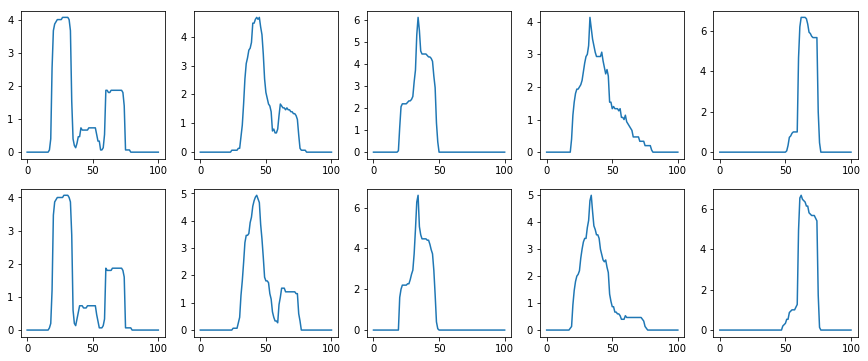

In [8]:
# calculate probability estimation for (center +- h/2) on the 10 data sets
h = .15
nCenters = 101
Centers = np.linspace(0,1,nCenters)

fig, ax = plt.subplots(2,5,figsize=(15,6))
ax = ax.ravel()
for i in range(10):
    ax[i].plot([P_est(center,h,data_3[0][i]) for center in Centers])

- Calculate the negative log-likelihood per datapoint of your estimator using 5000
samples from the data not used for the density estimation (i.e. the “test-set”). Get
the average of the negative log-likelihood over the 10 samples.

### $P(\{\underline{x}^{(\alpha)}\};\underline{w}) = - \Sigma_{\alpha=1}^{p} ln P(\underline{x}^{(\alpha)};\underline{w})$

In [9]:
testdata = img[0][50000:55000]

# calculate average negative log likelihood for 
def avg_NegLL(data, h, kernel=H):
    sys.stdout.write(".")
    average = 0
    for i in range(10):
        L_prob = [np.log(P_est(x,h,data[i],kernel)) for x in testdata]
        negLL = -1*np.sum(L_prob)
        average += negLL
    average /= 10
    return average

2) Repeat this procedure (without plotting) for a sequence of kernel widths h to get the mean
log likelihood (averaged over the different samples) resulting for each value of h.

(a) Apply this procedure to all 3 datasets (original and the two noise-corruped ones) to make
a plot showing the obtained likelihoods (y-axis) vs. kernel width h (x-axis) as one line for
each dataset.

In [10]:
hs = np.linspace(0.001, 0.999, 20)

def plot_negLL(data_3=data_3, kernel=H):
    fig = plt.figure(figsize=(12,8))
    for j in range(3):
        print("calc data[{}]".format(j))
        LLs = [avg_NegLL(data_3[j],h,kernel=kernel) for h in hs]
        plt.plot(hs,LLs)
        print()
    plt.legend(['img[0]', 'img[1]', 'img[2]'])
    plt.show()

calc data[0]
.

/home/georg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


...................
calc data[1]
....................
calc data[2]
....................


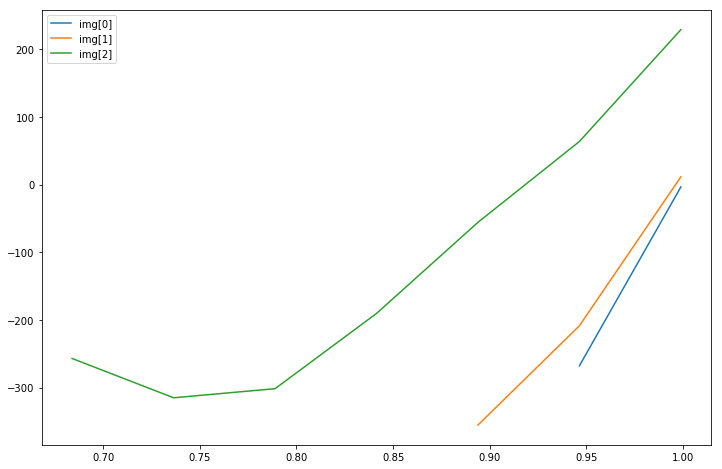

In [18]:
plot_negLL()

not plotted points have value = inf because:

$negLL = - log( \Pi_\alpha P(x^\alpha,w) )$

so if one single $P(x^\alpha,w) = 0$ occurs (x has 5000 elements)

the result is -log(0)=inf (not defined)

this only occurs with the histogram kernel.

(b) Repeat the previous step (LL & plot) for samples of size P = 500.

calc data[0]
.

/home/georg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


...................
calc data[1]
....................
calc data[2]
....................


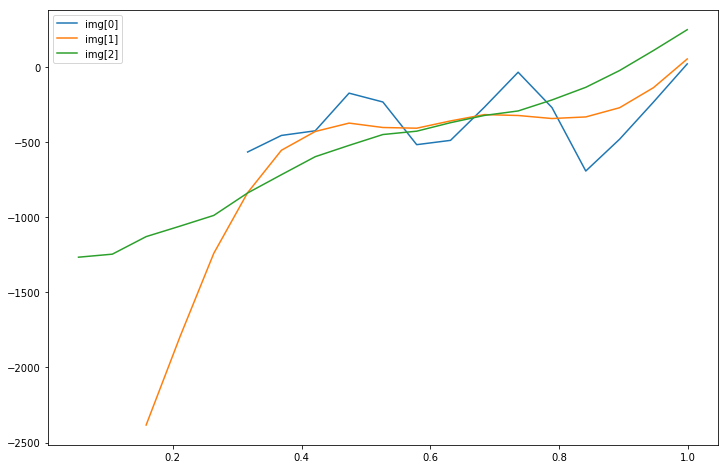

In [17]:
P = 500
data_3b = np.zeros((3, 10,P))
for j in range(3):
    for i in range(10):
        data_3b[j][i] = img[j][offset+i*P:offset+(i+1)*P]
        
plot_negLL(data_3=data_3b)

(c) Repeat the previous steps (a & b) for the Gaussian kernel with σ^2 = h.

In [12]:
def Gaussian(x,h):
    """
    gaussian kernel function
    """

    return np.exp(-x**2/h/2)/np.sqrt(2*np.pi*h)

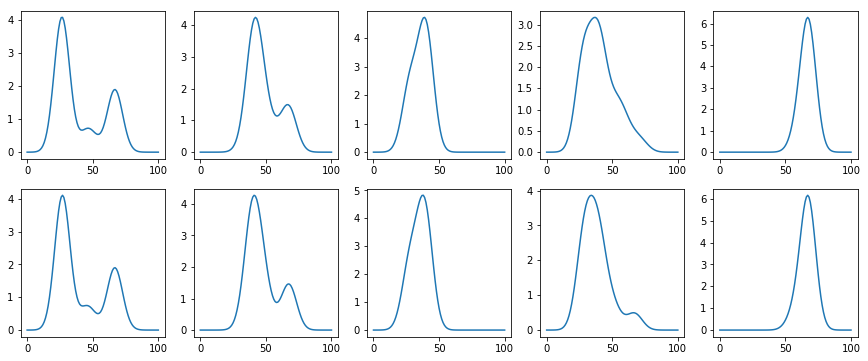

In [13]:
fig, ax = plt.subplots(2,5,figsize=(15,6))
h = .15

ax = ax.ravel()
for i in range(10):
    ax[i].plot([P_est(center,h,data_3[0][i],kernel=Gaussian) for center in Centers])

calc data[0]
.

/home/georg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


...................
calc data[1]
....................
calc data[2]
....................


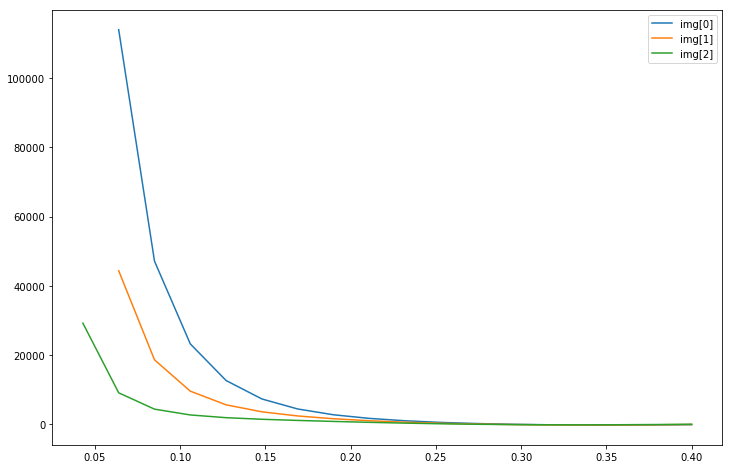

In [13]:
hs = np.linspace(0.001, 0.4, 20)
plot_negLL(kernel=Gaussian)

calc data[0]
.

/home/georg/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


...................
calc data[1]
....................
calc data[2]
....................


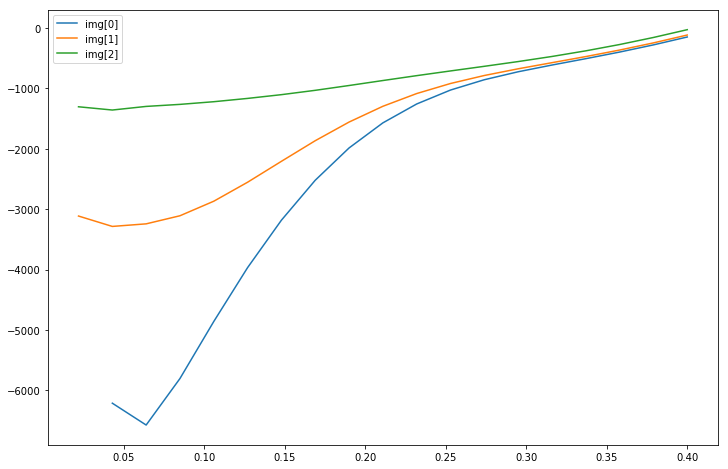

In [22]:
plot_negLL(data_3=data_3b, kernel=Gaussian)

## Exercise 2

### 1.1 Create dataset

In [17]:
M = 2
w1, w2 = [2,2], [1,1]  # means
sigma2 = 0.2  # standard deviations
N = 100
P1, P2 = 2/3, 1/3

def create_data(sigma1=0.7):
    X = np.zeros((N, 2))
    which_gaussian = np.zeros(N)

    for n in range(N):
        if np.random.rand() < P1:  # sample from first Gaussian
            X[n] = np.random.multivariate_normal(w1, np.eye(len(w1)) * sigma1**2)
            which_gaussian[n] = 0
        else:  # sample from second Gaussian
            X[n] = np.random.multivariate_normal(w2, np.eye(len(w2)) * sigma2**2)
            which_gaussian[n] = 1
            
    return X, which_gaussian

sigma1 = 0.7
X, which_gaussian = create_data(sigma1)

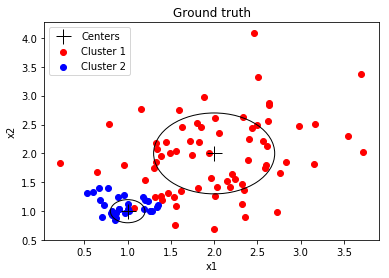

In [18]:
def plot_data(X, which_gaussian, centers, stds):
    plt.scatter(*X[which_gaussian == 0].T, c='r', label='Cluster 1')
    plt.scatter(*X[which_gaussian == 1].T, c='b', label='Cluster 2')
    plt.plot(centers[0][0], centers[0][1], 'k+', markersize=15, label='Centers')
    plt.plot(centers[1][0], centers[1][1], 'k+', markersize=15)
    plt.gca().add_artist(plt.Circle(centers[0], stds[0], ec='k', fc='none'))
    plt.gca().add_artist(plt.Circle(centers[1], stds[1], ec='k', fc='none'))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    
plot_data(X, which_gaussian, [w1, w2], [sigma1, sigma2])
plt.title('Ground truth')

### 1.2 Run Expectation-Maximization algorithm
See slide 18 of the lecture for an outline of the algorithm.

In [19]:
from scipy.stats import multivariate_normal

def variance(X):
    """Calculate a single variance value for the vectors in X."""
    mu = X.mean(axis=0)
    return np.mean([np.linalg.norm(x - mu)**2 for x in X])

def run_expectation_maximization(X, w=None, sigma_squared=None, verbose=False):
    # Initialization.
    P_prior = np.ones(2) * 1 / M
    P_likelihood = np.zeros((N, M))
    P_posterior = np.zeros((M, N))
    
    mu = X.mean(axis=0)  # mean of the original data
    var = variance(X)  # variance of the original data

    if w is None:
        w = np.array([mu + np.random.rand(M) - 0.5, mu + np.random.rand(M) - 0.5])

    if sigma_squared is None:
        sigma_squared = np.array([var + np.random.rand() - 0.5,var + np.random.rand() - 0.5])
        #sigma_squared = np.array([var, var])

    if verbose:
        print('Initial centers:', w)
        print('Initial variances:', sigma_squared)
        print()
        print()


    theta = 0.001
    distance = np.inf
    step = 0


    # Optimization loop.
    while distance > theta:
    #for i in range(1):
        step += 1
        if verbose:
            print('Step', step)
            print('-'*50)

        # Store old parameter values to calculate distance later on.
        w_old = w.copy()
        sigma_squared_old = sigma_squared.copy()
        P_prior_old = P_prior.copy()

        if verbose:
            print('Distances of X[0] to proposed centers:', np.linalg.norm(X[0] - w[0]), np.linalg.norm(X[0] - w[1]))

        # E-Step: Calculate likelihood for each data point.
        for (alpha, q), _ in np.ndenumerate(P_likelihood):
            P_likelihood[alpha, q] = multivariate_normal.pdf(X[alpha], w[q], sigma_squared[q])

        if verbose:
            print('Likelihoods of X[0]:', P_likelihood[0])

        # E-Step: Calculate assignment probabilities (posterior) for each data point.
        for (q, alpha), _ in np.ndenumerate(P_posterior):
            P_posterior[q, alpha] = (P_likelihood[alpha, q] * P_prior[q]) / np.sum([P_likelihood[alpha, r] * P_prior[r] for r in range(M)])

        if verbose:
            print('Assignment probabilities of X[0]:', P_posterior[:, 0])
            print()

        distance = 0
        # M-Step: Calculate new parameter values.
        for q in range(M):
            w[q] = np.sum([P_posterior[q, alpha] * X[alpha] for alpha in range(N)], axis=0) / np.sum(P_posterior[q])
            #print(np.sum([P_posterior[q, alpha] * X[alpha] for alpha in range(N)], axis=0))
            #print(np.sum(P_posterior[q]))
            w_distance = np.linalg.norm(w[q] - w_old[q])
            if verbose:
                print('Distance of centers:', w_distance)
            distance = max(distance, w_distance)

            sigma_squared[q] = 1 / M * np.sum([np.linalg.norm(X[alpha] - w_old[q])**2 * P_posterior[q, alpha] for alpha in range(N)]) / np.sum(P_posterior[q])
            sigma_squared_distance = np.abs(sigma_squared[q] - sigma_squared_old[q])
            if verbose:
                print('Distance of variances:', sigma_squared_distance)
            distance = max(distance, sigma_squared_distance)

            P_prior[q] = np.mean(P_posterior[q])
            P_prior_distance = np.abs(P_prior[q] - P_prior_old[q])
            if verbose:
                print('Distance of priors:', P_prior_distance)
            distance = max(distance, P_prior_distance)


        if verbose:
            print('Maximum distance:', distance)

            print()
            print('New centers:', w)
            print('New variances:', sigma_squared)
            print('New priors:', P_prior)

            print('='*50)
            print()

    which_gaussian_EM = P_posterior.argmax(axis=0)
    
    return which_gaussian_EM, w, np.sqrt(sigma_squared), step

which_gaussian_em, cluster_centers_em, cluster_stds_em, num_steps_em = run_expectation_maximization(X, verbose=True)

Initial centers: [[ 1.53518244  1.92693386]
 [ 1.49432597  1.95412241]]
Initial variances: [ 1.20752752  1.40122925]


Step 1
--------------------------------------------------
Distances of X[0] to proposed centers: 1.07545424393 1.11929886145
Likelihoods of X[0]: [ 0.08164578  0.07263752]
Assignment probabilities of X[0]: [ 0.52919388  0.47080612]

Distance of centers: 0.280723619496
Distance of variances: 0.65552846138
Distance of priors: 0.0234334427061
Distance of centers: 0.321569568555
Distance of variances: 0.805770461625
Distance of priors: 0.0234334427061
Maximum distance: 0.805770461625

New centers: [[ 1.68565079  1.68994225]
 [ 1.69703919  1.70449401]]
New variances: [ 0.55199906  0.59545879]
New priors: [ 0.52343344  0.47656656]

Step 2
--------------------------------------------------
Distances of X[0] to proposed centers: 0.925878542461 0.912824005713
Likelihoods of X[0]: [ 0.13263358  0.13277191]
Assignment probabilities of X[0]: [ 0.52317341  0.47682659]

Distance of 

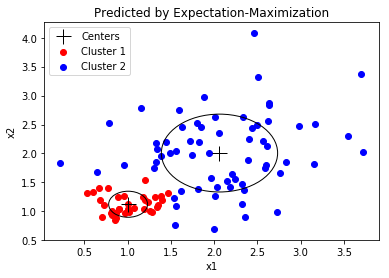

In [20]:
plot_data(X, which_gaussian_em, cluster_centers_em, cluster_stds_em)
plt.title('Predicted by Expectation-Maximization')

### 1.3 Run K-means algorithm
For simplicity, we use the sklearn version of K-means here. The detailed algorithm was already implemented in a previous exercise. 

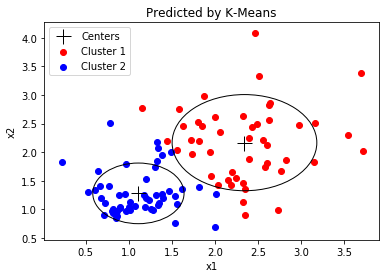

In [21]:
from sklearn.cluster import KMeans

def run_k_means(X):
    km = KMeans(2)
    km.fit(X)
    which_gaussian_km = km.predict(X)
    cluster_stds = np.array([np.sqrt(variance(X[which_gaussian_km == 0])), np.sqrt(variance(X[which_gaussian_km == 1]))])
    return which_gaussian_km, km.cluster_centers_, cluster_stds

which_gaussian_km, cluster_centers_km, cluster_stds_km = run_k_means(X)

plot_data(X, which_gaussian_km, cluster_centers_km, cluster_stds_km)
plt.title('Predicted by K-Means')

K-means clusters the data point by establishing a straight separation line. This cannot fully capture the nature of the data, e.g. the points around the lower left Gaussian, which actually belong to the upper right Gaussian.

### 1.4 Initialize EM algorithm with cluster parameters from K-Means

In [22]:
_, _, _, num_steps_em_km = run_expectation_maximization(X, cluster_centers_km, cluster_stds_km**2)

print('Took', num_steps_em, 'steps with random initalization')
print('Took', num_steps_em_km, 'steps with initialization from K-means')

Took 27 steps with random initalization
Took 18 steps with initialization from K-means


### 1.5 Repeat analysis for different $\sigma_1$ values

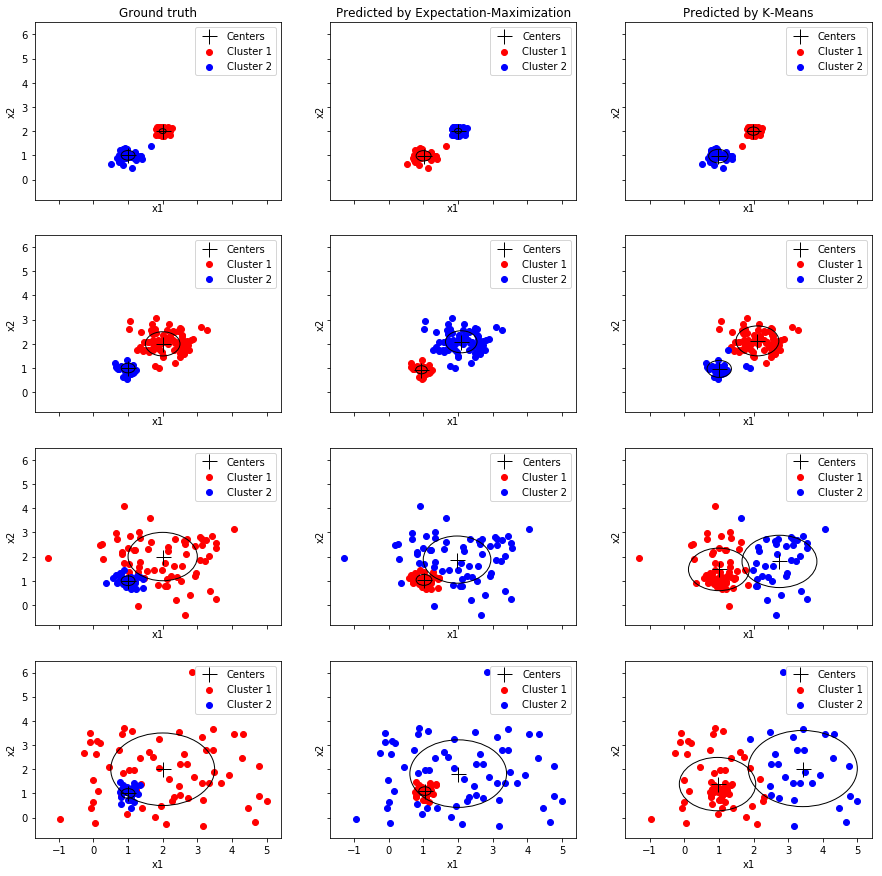

In [23]:
sigma1s = [0.1, 0.5, 1, 1.5]
fig, axes = plt.subplots(len(sigma1s), 3, figsize=(15, 15), sharex=True, sharey=True)

for i, (sigma1, horizontal_axes) in enumerate(zip(sigma1s, axes)):
    X, which_gaussian = create_data(sigma1)
    
    plt.sca(horizontal_axes[0])
    plot_data(X, which_gaussian, [w1, w2], [sigma1, sigma2])
    if i == 0:
        plt.title('Ground truth')
        
    which_gaussian_em, cluster_centers_em, cluster_stds_em, num_steps_em = run_expectation_maximization(X)
    plt.sca(horizontal_axes[1])
    plot_data(X, which_gaussian_em, cluster_centers_em, cluster_stds_em)
    if i == 0:
        plt.title('Predicted by Expectation-Maximization')
        
    which_gaussian_km, cluster_centers_km, cluster_stds_km = run_k_means(X)
    plt.sca(horizontal_axes[2])
    plot_data(X, which_gaussian_km, cluster_centers_km, cluster_stds_km)
    if i == 0:
        plt.title('Predicted by K-Means')

Each row corresponds to increasing $\sigma_1$ (the values are 0.1, 0.5, 1, 1.5).

K-means and Expectation-Maximization show similar results for small $\sigma_1$, i.e. if the clusters are clearly separated. With increasing $\sigma_1$, the Gaussians overlap more and more, and K-means fails to cluster them correctly.